In [13]:
import awswrangler as wr

def get_symbols():
    # S&P 500
    df = wr.s3.read_csv("s3://faysal/stocks/symbols/sp500.csv")
    symbols = list(df["Symbol"].values)
    # S&P 400 MidCaps
    df = wr.s3.read_csv("s3://faysal/stocks/symbols/sp400.csv")
    symbols.extend(df["Symbol"].values)
    # S&P 600 SmallCaps
    df = wr.s3.read_csv("s3://faysal/stocks/symbols/sp600.csv")
    symbols.extend(df["Symbol"].values)

    return [s.upper() for s in symbols if isinstance(s, str)]

symbols = get_symbols()

In [2]:
from OutsideWorld.Investing.Screener import Screener, ScreeningCriteria, ScreeningResult

screener = Screener()
criteria: ScreeningCriteria = ScreeningCriteria(
    country = "US",
    min_market_cap = 250000000,
    min_volume = None,
    min_dividend = None,
    max_beta = None,
    is_etf = False,
    is_actively_trading = True
)

symbols: ScreeningResult = screener.screen(criteria=criteria)

screened_symbols = [s.symbol for s in symbols]
screened_symbols = [s.split(".")[0] for s in screened_symbols]
screened_symbols = [s for s in screened_symbols if len(s) < 5 and "0" not in s]
screened_symbols = list(set(screened_symbols))


In [ ]:
#todo:
# kill BDCs, Reits, closed-end, pharma < 30B, banks, insurance
# add profile, sector, industry
# compare to peers, sector/industry
# kill negative eps
# kill gambling, "industry": "Entertainment",  Gambling
# add growth in net margin
# add commondities prices (oil) to the summary
#qoq calc for oe look wrong?
# add net margin increase
# add summary of changes that now make trigger
# add some leverage charts
# add some upper limit on goodwill to assets ratio

In [25]:
import pickle
rejects = []

with open("../data/existing_matches.pickle", "wb") as f:
    pickle.dump(rejects, f)

This feeds a rolling list which another app montiors
2nd app looks for the first trading day with a significant positive gain, that's the buy trigger.
Expires after 40 trading days.
2nd app keeps list of triggers, 1st app won't retrigger until expired. 

have to define what a good entry looks like when undervalued is detected.  see VSH.

In [183]:
with open("../data/existing_matches.pickle", "rb") as f:
    existing_matches = pickle.load(f)

[x for x in existing_matches]


EOFError: Ran out of input

In [11]:
rejects = ["FTDR"]
import pickle
with open("../data/rejects.pickle", "wb") as f:
    pickle.dump(rejects, f)

In [26]:
matches = []
from fetch_data import fetch_data
import numpy as np
import datetime
import pickle 

start_dt = datetime.datetime.today() - datetime.timedelta(weeks=78)

for s in screened_symbols:
    try:
        #df = fetch_data(s, start_dt.isoformat()[0:10])
        with open(f"../data/dfs/{s}.pickle", "rb") as f:
            df = pickle.load(f)
        
        col = "ratio_pe"
        df["stdevs"] = (df[col] - np.mean(df[col])) / np.std(df[col])

        # persist
        with open(f"../data/dfs/{s}.pickle", "wb") as f:
            pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

        test_day = df.iloc[-5]


        if  test_day["atoi_lag_1"] > 0 and \
            test_day["atoi"] > 0 and \
            test_day["atoi_qoq_growth"] > -0.05 and \
            test_day["owners_earnings_lag_1"] > 0 and \
            test_day["owners_earnings"] > 0 and \
            test_day["owners_earnings_qoq_growth"] > 0 and \
            test_day["owners_earnings_qoq_growth_lag_1"] > 0 and \
            test_day["net_margin"] > 0.11 and \
            test_day["net_margin_growth"] > 0 and \
            test_day["roic"] > 0.15 and \
            test_day["totalStockholdersEquity"] > 0 and \
            test_day["ratio_peg"] < 1 and \
            test_day["stdevs"] < -1.25:
            

            # match found
            today = df.iloc[-1]
            gain = round(( today["marketCap"] - test_day["marketCap"] ) / test_day["marketCap"] * 100, 2)

            print(f"{s}: {test_day.name} to {today.name} gain: {gain} | \t net_margin: {test_day['net_margin']} \t ratio_netDebt_to_ebitda: {test_day['ratio_netDebt_to_ebitda']}")
            # print(s)
            # matches.append(s)

    except Exception as e:
        continue

NE: 2024-02-02 00:00:00 to 2024-02-08 00:00:00 gain: 3.04 | 	 net_margin: 0.18187275634374886 	 ratio_netDebt_to_ebitda: 0.5344845422228353
LPG: 2024-02-02 00:00:00 to 2024-02-08 00:00:00 gain: 1.32 | 	 net_margin: 0.5352039738927431 	 ratio_netDebt_to_ebitda: 1.6419814706441325
ABNB: 2024-02-02 00:00:00 to 2024-02-08 00:00:00 gain: 2.72 | 	 net_margin: 0.5686556608686595 	 ratio_netDebt_to_ebitda: -2.0410577592205983
WHD: 2024-02-02 00:00:00 to 2024-02-08 00:00:00 gain: 4.93 | 	 net_margin: 0.19161415155248013 	 ratio_netDebt_to_ebitda: -0.03757282416123783


In [66]:
from fetch_data import fetch_data

df = fetch_data("EQIX", "2022-10-23")



import matplotlib.pyplot as plt

x = df.index
y = df["roic"]

import pdf_utils
from matplotlib.backends.backend_pdf import PdfPages

# pdf = PdfPages("test.pdf")
# pdf_utils.add_plot_to_pdf("PEG", x,df["ratio_peg"], pdf)
# pdf_utils.add_plot_to_pdf("ROIC", x,df["roic"], pdf)
# pdf.close()


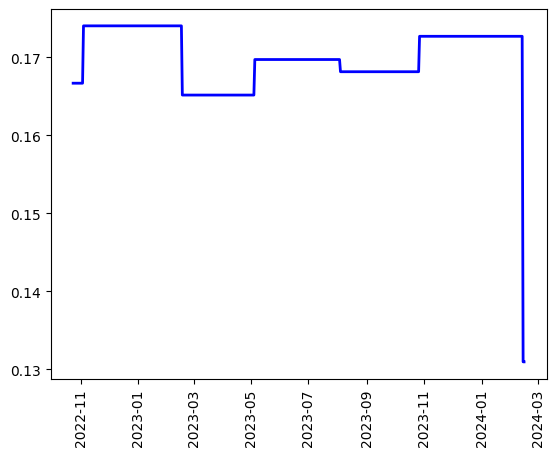

In [67]:
y = df["roic"]

plt.plot(x,y, color="blue", linewidth=2, markersize=4, label = "P/E")
plt.xticks(rotation=90)
plt.show()

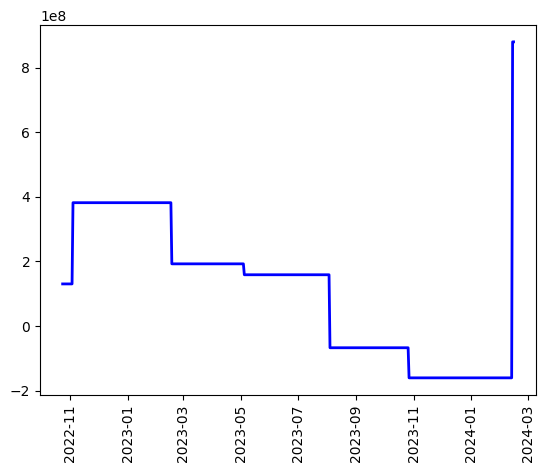

In [68]:
y = df["owners_earnings"]

plt.plot(x,y, color="blue", linewidth=2, markersize=4, label = "P/E")
plt.xticks(rotation=90)
plt.show()

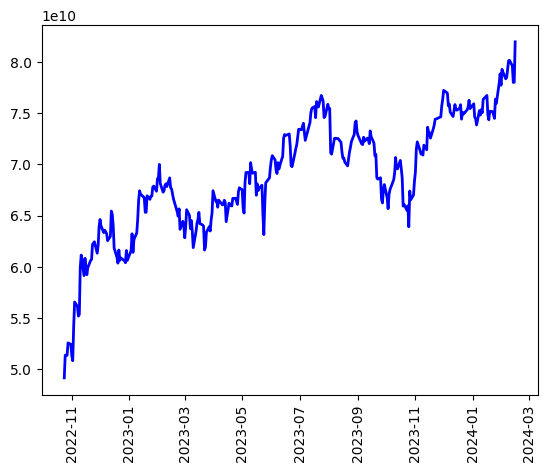

In [69]:
y = df["marketCap"]

plt.plot(x,y, color="blue", linewidth=2, markersize=4, label = "P/E")
plt.xticks(rotation=90)
plt.show()

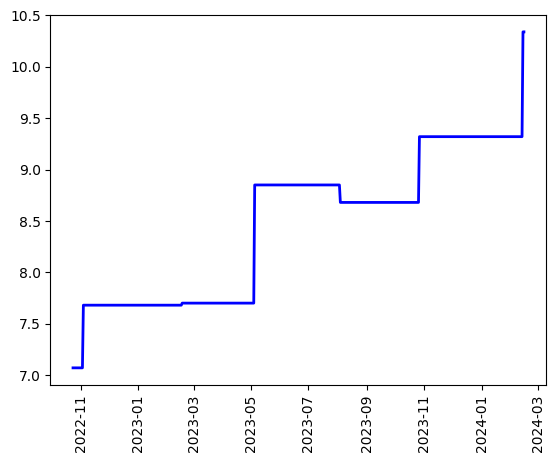

In [70]:
plt.plot(x,df["eps"], color="blue", linewidth=2, markersize=4, label = "P")
plt.xticks(rotation=90)
plt.show()

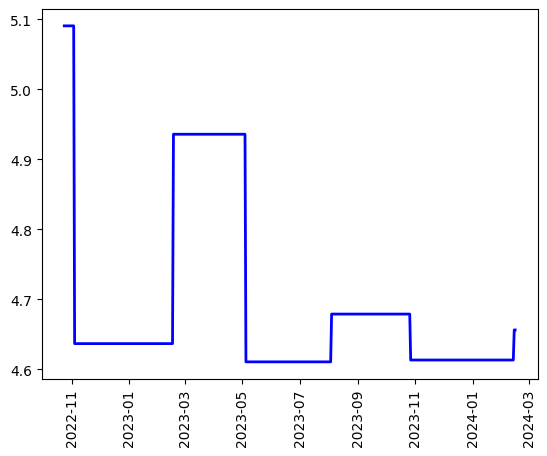

In [71]:

plt.plot(x,df["ratio_netDebt_to_ebitda"], color="blue", linewidth=2, markersize=4, label = "P")
plt.xticks(rotation=90)
plt.show()


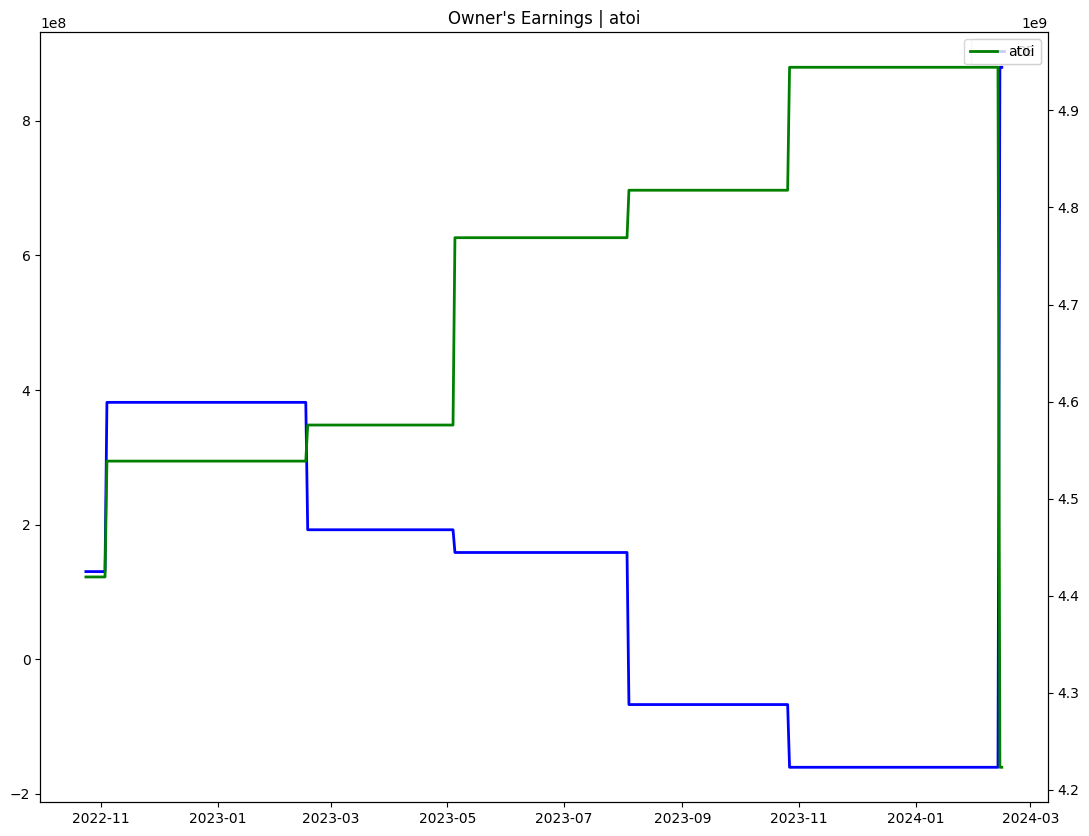

In [72]:
plt.figure(figsize=(13, 10))  
plt.plot(x,df["owners_earnings"], color="blue", linewidth=2, markersize=4, label = "OE")
plt.legend()
plt.twinx()
plt.plot(x,df["atoi"], color="green", linewidth=2, markersize=4, label = "atoi")
plt.legend()
plt.xticks(rotation=90)
plt.title("Owner's Earnings | atoi")

plt.show()

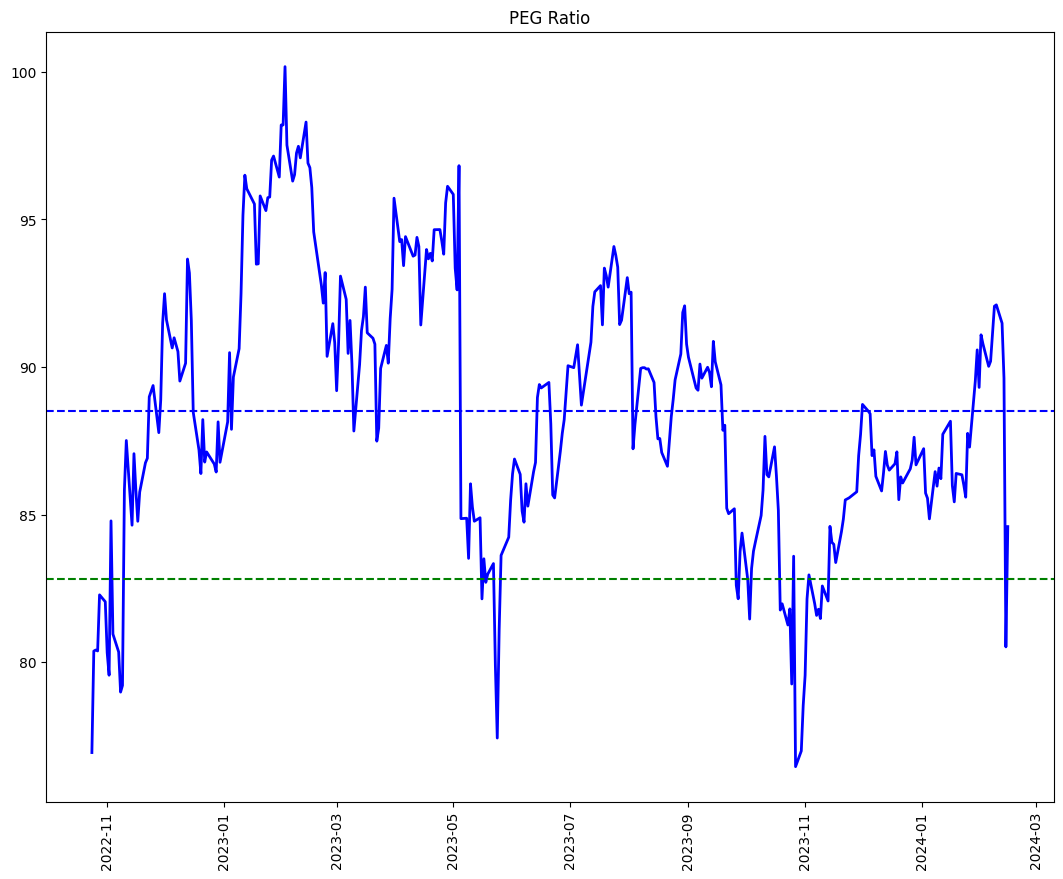

In [73]:
plt.figure(figsize=(13, 10))  
plt.plot(x,df["ratio_pe"], color="blue", linewidth=2, markersize=4, label = "P")
plt.xticks(rotation=90)
plt.title("PEG Ratio")
plt.axhline(y=(df["ratio_pe"].mean()), color="blue", linestyle="--")
plt.axhline(y=(df["ratio_pe"].mean() - 1.25*df["ratio_pe"].std()), color="green", linestyle="--")
plt.show()

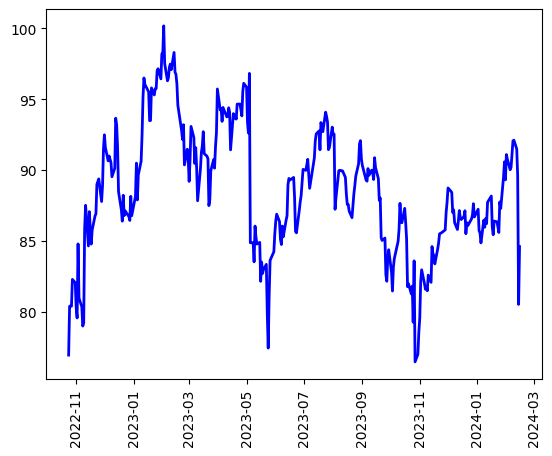

In [74]:
import numpy as np

#a = (np.mean(df["ratio_pe"]), np.stdev(df["ratio_pe"]))

col = "ratio_pe"
df["stdevs"] = (df[col] - np.mean(df[col])) / np.std(df[col])
# df["net_margin_lag_1"] = df["net_margin"].shift(1)
# df["net_margin_qoq_growth"] = (df["net_margin"] - df["net_margin_lag_1"]) / df["net_margin_lag_1"]

plt.plot(x,df["ratio_pe"], color="blue", linewidth=2, markersize=4, label = "P")
plt.xticks(rotation=90)
plt.show()